<a href="https://colab.research.google.com/github/iamajarpit/Blur_image_detection/blob/main/Blur_Detection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(folder, filename),
            target_size=(224, 224)  # Resize images to a consistent size
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img)
    return np.array(images)

blur_images = load_images_from_folder('/content/drive/MyDrive/BLUR DATASET/blur')
non_blur_images = load_images_from_folder('/content/drive/MyDrive/BLUR DATASET/Non blur')

# Create labels (1 for blur, 0 for non-blur)
blur_labels = np.ones(len(blur_images))
non_blur_labels = np.zeros(len(non_blur_images))

# Concatenate images and labels
X = np.concatenate((blur_images, non_blur_images), axis=0)
y = np.concatenate((blur_labels, non_blur_labels), axis=0)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Adjust batch size and steps per epoch as needed
    epochs=10,
    validation_data=(X_val, y_val)
)


Epoch 1/10
26/26 [==============================] - 130s 5s/step - loss: 0.3335 - accuracy: 0.8676 - val_loss: 0.5860 - val_accuracy: 0.7667
Epoch 2/10
26/26 [==============================] - 116s 4s/step - loss: 0.3543 - accuracy: 0.8626 - val_loss: 0.3453 - val_accuracy: 0.8810
Epoch 3/10
26/26 [==============================] - 111s 4s/step - loss: 0.3339 - accuracy: 0.8787 - val_loss: 0.2913 - val_accuracy: 0.9048
Epoch 4/10
26/26 [==============================] - 112s 4s/step - loss: 0.4057 - accuracy: 0.8465 - val_loss: 0.4715 - val_accuracy: 0.7762
Epoch 5/10
26/26 [==============================] - 140s 5s/step - loss: 0.3145 - accuracy: 0.8936 - val_loss: 0.5185 - val_accuracy: 0.7667
Epoch 6/10
26/26 [==============================] - 124s 5s/step - loss: 0.3437 - accuracy: 0.8676 - val_loss: 0.4359 - val_accuracy: 0.8095
Epoch 7/10
26/26 [==============================] - 111s 4s/step - loss: 0.3181 - accuracy: 0.8837 - val_loss: 0.2645 - val_accuracy: 0.8905
Epoch 8/10
26

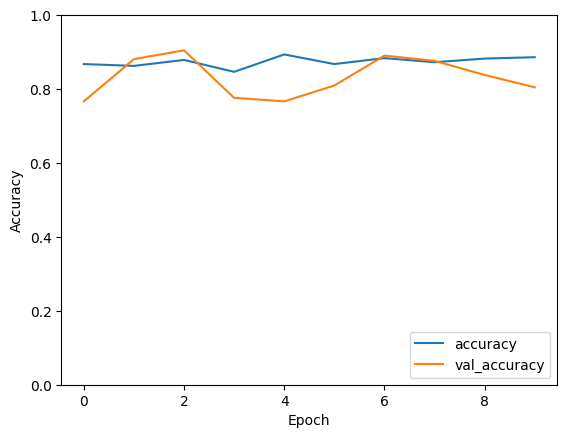

7/7 - 7s - loss: 0.4191 - accuracy: 0.8048 - 7s/epoch - 1s/step
Test accuracy: 0.8047618865966797


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'Test accuracy: {test_acc}')


In [ ]:
# Save the trained model to a file
model.save('blur_detection_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model_path = '/content/blur_detection_model.h5'  # Update the path to your model
loaded_model = load_model(model_path)

def is_blurred(image_path, threshold=0.4):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size
    img = img_to_array(img) / 255.0  # Convert to array and normalize pixel values

    # Expand dimensions to match model input shape
    img = np.expand_dims(img, axis=0)

    # Predict blur probability
    prediction = loaded_model.predict(img)

    # Check if blur probability exceeds threshold
    if prediction[0][0] >= threshold:
        return True
    else:
        return False

# Example usage
image_path = '/content/drive/MyDrive/BLUR DATASET/blur/105_IPHONE-SE_M.jpg'  # Update the path to your test image
is_blur = is_blurred(image_path)

if is_blur:
    print('The image is blurred.')
else:
    print('The image is not blurred.')


1/1 [==============================] - 0s 116ms/step
The image is blurred.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import cv2
import numpy as np

# Load the trained model
model_path = '/content/blur_detection_model.h5'  # Update this path to your saved model location
model = load_model(model_path)

# Function to predict if an image is blurred or not
def is_blurred(image_path, model, threshold=0.4):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB format
    img = cv2.resize(img, (224, 224))  # Resize image to match model input size
    img = img_to_array(img) / 255.0  # Convert to array and normalize pixel values

    # Expand dimensions to match model input shape
    img = np.expand_dims(img, axis=0)

    # Predict blur probability
    prediction = model.predict(img)

    # Check if blur probability exceeds threshold
    if prediction[0][0] >= threshold:
        return True
    else:
        return False

# Example usage with a placeholder path
test_image_path = '/content/drive/MyDrive/BLUR DATASET/blur/105_IPHONE-SE_M.jpg'  # Update this path to your test image location
print(is_blurred(test_image_path, model))


1/1 [==============================] - 0s 118ms/step
True
